In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import time
import re
import scipy
from datetime import time, timedelta
import seaborn as sns
pd.set_option('display.max_columns', 100)

def trans_float(df):
    for i in df.columns:
        if df[i].dtype == object:
            if ((df[i]== 'None')|(df[i]== 'Null')).any():
                df[i].replace('None',np.nan,inplace = True)
                df[i].replace('Null',np.nan,inplace = True)
                df[i] = df[i].astype(float)
            else:
                df[i] = df[i].astype(float)

In [2]:
from dateutil.parser import parse

In [3]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return parse(t)

# 读取micro cohort

In [4]:
cohort_WITHMDR = pd.read_csv('cohort_WITHMDR.csv',low_memory=False)

In [5]:
#cohort_WITHMDR = cohort_WITHMDR[cohort_WITHMDR['SPECIMEN']== '静脉血']

In [6]:
#cohort_WITHMDR = cohort_WITHMDR[cohort_WITHMDR.org_category.isin(cohort_WITHMDR.org_category.value_counts().index)]

In [7]:
cohort_WITHMDR[(cohort_WITHMDR['AGE']>=18)][['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(38155, 2)

In [8]:
cohort_WITHMDR = cohort_WITHMDR[['PATIENT_ID', 'SPECIMEN', 
       'REQUESTED_DATE_TIME', 'RESULTS_RPT_DATE_TIME', 'SUBJECT', 'ITEM_NO',
       'REPORT_ITEM_NAME', 'micro_name', '万古霉素', '亚胺培南',
       '克林霉素', '利奈唑胺', '利福平', '厄它培南', '哌拉西林', '哌拉西林/他唑巴坦', '喹努普汀/达福普汀', '四环素',
       '复方新诺明', '头孢他啶', '头孢吡肟', '头孢呋辛', '头孢呋辛酯', '头孢唑啉', '头孢曲松', '头孢替坦',
       '头孢西丁', '妥布霉素', '左旋氧氟沙星', '庆大霉素', '替加环素', '替考拉宁', '氨曲南', '氨苄西林',
       '氨苄西林/舒巴坦', '环丙沙星', '磷霉素', '米诺环素', '红霉素', '美洛培南', '苯唑西林', '苯唑青霉素',
       '莫西沙星', '阿米卡星', '阿莫西林/棒酸', '青霉素', '青霉素G', '高水平庆大霉素', '高水平链霉素',
       'resistant_ab_cat', 'MDR', 'org_category', 'org_pos', 'org_neg',
       'VISIT_ID', 'GENDER', 'AGE', 'ADMISSION_DATE_TIME',
       'DISCHARGE_DATE_TIME', 'ADMISSION_TYPE', 'ICU_TYPE',
       'TF_ADMISSION_DATE_TIME', 'TF_DISCHARGE_DATE_TIME', 'LOS_ICU',
       'firsthospmdrcharttime', 'firsthospmdrstoretime', 'firsthospmdrRAB',
       'firsthospmdrorgname', 'microtest_days', 'microresult_days',
       'microtest_inicu', 'microtest_beforeicu', 'microresult_beforeicu']]

In [9]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return np.datetime64(t)

for i in ['REQUESTED_DATE_TIME','RESULTS_RPT_DATE_TIME','TF_ADMISSION_DATE_TIME','TF_DISCHARGE_DATE_TIME','ADMISSION_DATE_TIME','DISCHARGE_DATE_TIME']:
    cohort_WITHMDR[i] = cohort_WITHMDR[i].apply(trans_time)

# 检出时间

In [10]:
#检出MDR的时间在第一天住ICU之前(本次住院期间)
cohort_all_mdrpos_beforeicu1stday =  cohort_WITHMDR[(cohort_WITHMDR['MDR'] == 1)&\
                                                 (cohort_WITHMDR['org_pos'] == 1)&\
                    (((cohort_WITHMDR['RESULTS_RPT_DATE_TIME']-cohort_WITHMDR['TF_ADMISSION_DATE_TIME']).dt.total_seconds()/3600)<=24)]

cohort_all_mdrneg_beforeicu1stday =  cohort_WITHMDR[(cohort_WITHMDR['MDR'] == 1)&\
                                                 (cohort_WITHMDR['org_neg'] == 1)&\
                    (((cohort_WITHMDR['RESULTS_RPT_DATE_TIME']-cohort_WITHMDR['TF_ADMISSION_DATE_TIME']).dt.total_seconds()/3600)<=24)]

In [11]:
#在住ICU第一个24小时前最近一次检出MDRO
cohort_all_lastmdrpos_beforeicu1stday = cohort_all_mdrpos_beforeicu1stday.drop_duplicates().groupby(['PATIENT_ID','TF_ADMISSION_DATE_TIME']).\
apply(lambda x: x.sort_values(['RESULTS_RPT_DATE_TIME'],ascending = False).head(1)).reset_index(drop = True)

cohort_all_lastmdrneg_beforeicu1stday = cohort_all_mdrneg_beforeicu1stday.drop_duplicates().groupby(['PATIENT_ID','TF_ADMISSION_DATE_TIME']).\
apply(lambda x: x.sort_values(['RESULTS_RPT_DATE_TIME'],ascending = False).head(1)).reset_index(drop = True)

#最近一次检出MDRO的信息，以及是否在-30至1天内
cohort_all_lastmdrpos_beforeicu1stday = cohort_all_lastmdrpos_beforeicu1stday[['PATIENT_ID','TF_ADMISSION_DATE_TIME',\
                                                           'REQUESTED_DATE_TIME','RESULTS_RPT_DATE_TIME','micro_name','resistant_ab_cat']].\
rename(columns = {'REQUESTED_DATE_TIME':'lastbeforeicu1stday_mdrposcharttime',\
                  'RESULTS_RPT_DATE_TIME':'lastbeforeicu1stday_mdrposstoretime',\
                  'micro_name':'lastbeforeicu1stday_mdrposorgname',\
                 'resistant_ab_cat':'lastbeforeicu1stday_mdrposRAB'})

cohort_all_lastmdrneg_beforeicu1stday = cohort_all_lastmdrneg_beforeicu1stday[['PATIENT_ID','TF_ADMISSION_DATE_TIME',\
                                                           'REQUESTED_DATE_TIME','RESULTS_RPT_DATE_TIME','micro_name','resistant_ab_cat']].\
rename(columns = {'REQUESTED_DATE_TIME':'lastbeforeicu1stday_mdrnegcharttime',\
                  'RESULTS_RPT_DATE_TIME':'lastbeforeicu1stday_mdrnegstoretime',\
                  'micro_name':'lastbeforeicu1stday_mdrnegorgname',\
                 'resistant_ab_cat':'lastbeforeicu1stday_mdrnegRAB'})

# 阳性阴性分类

In [12]:
#positive
cohort_WITHMDR_withlastall = pd.merge(cohort_WITHMDR, cohort_all_lastmdrpos_beforeicu1stday,how = 'left', on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME'])

cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoreday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoretime'] - \
                                                                   cohort_WITHMDR_withlastall['TF_ADMISSION_DATE_TIME']).\
dt.total_seconds()/(3600*24)
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposchartday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposcharttime'] - \
                                                                   cohort_WITHMDR_withlastall['TF_ADMISSION_DATE_TIME']).\
dt.total_seconds()/(3600*24)

#negative
cohort_WITHMDR_withlastall = pd.merge(cohort_WITHMDR_withlastall, cohort_all_lastmdrneg_beforeicu1stday,how = 'left', on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME'])

cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoreday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoretime'] - \
                                                                   cohort_WITHMDR_withlastall['TF_ADMISSION_DATE_TIME']).\
dt.total_seconds()/(3600*24)
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegchartday'] = (cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegcharttime'] - \
                                                                   cohort_WITHMDR_withlastall['TF_ADMISSION_DATE_TIME']).\
dt.total_seconds()/(3600*24)

In [13]:
#cohort_WITHMDR_withlastall[cohort_WITHMDR_withlastall['subject_id'] == 10004401].to_csv('test.csv')

cohort_WITHMDR_withlastall['previous_mdrpos_lessthan14d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoreday'].apply(lambda x: 1 if -14<=x<=1 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['previous_mdrneg_lessthan14d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoreday'].apply(lambda x: 1 if -14<=x<=1 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['previous_mdrpos_lessthan90d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrposstoreday'].apply(lambda x: 1 if -90<=x<-14 else 0) #-24*30<x<24

cohort_WITHMDR_withlastall['previous_mdrneg_lessthan90d'] = \
cohort_WITHMDR_withlastall['lastbeforeicu1stday_mdrnegstoreday'].apply(lambda x: 1 if -90<=x<-14 else 0) #-24*30<x<24


In [14]:
# spec_type = cohort_WITHMDR_withlastall[['subject_id','micro_specimen_id','org_name','spec_type_desc']]

# spec_type_dum = pd.get_dummies(spec_type, columns = ['spec_type_desc'])

# spec_type_SEL = spec_type_dum[[\
#                'spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE',\
#                'spec_type_desc_SWAB','spec_type_desc_SPUTUM','spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']]

# cohort_WITHMDR_withlastall = pd.concat([cohort_WITHMDR_withlastall, spec_type_SEL], axis = 1)

# 标签

In [15]:
#微生物检查及出结果时间与住ICU时间之差
cohort_WITHMDR_withlastall['chart_inttime']=(cohort_WITHMDR_withlastall['REQUESTED_DATE_TIME']-cohort_WITHMDR_withlastall['TF_ADMISSION_DATE_TIME']).\
dt.total_seconds()/3600
cohort_WITHMDR_withlastall['store_inttime']=(cohort_WITHMDR_withlastall['RESULTS_RPT_DATE_TIME']-cohort_WITHMDR_withlastall['TF_ADMISSION_DATE_TIME']).\
dt.total_seconds()/3600

cohort_WITHMDR_withlastall['chart_included'] = cohort_WITHMDR_withlastall['chart_inttime'].\
apply(lambda x: 1 if -24<=x<=24 else 0)

cohort_WITHMDR_withlastall['chart_included_mdr'] = cohort_WITHMDR_withlastall[['chart_included','MDR']].\
apply(lambda x:1 if (x[0]==1)&(x[1]==1) else 0, axis = 1)

In [16]:
def sel_stay_chart_included(df):
    df_0 = df
    if (df_0['chart_included'] == 1).any():
        return 1
    elif (df_0['chart_included'] == 0).all():
        return 0 
    else:
        return np.nan

stay_chart_included_df = cohort_WITHMDR_withlastall.groupby(['PATIENT_ID','TF_ADMISSION_DATE_TIME']).apply(sel_stay_chart_included)
stay_chart_included_df = pd.DataFrame(stay_chart_included_df,columns= ['stay_chart_included']).reset_index()

def sel_stay_chart_included_mdr(df):
    df_0 = df
    if (df_0['chart_included_mdr'] == 1).any():
        return 1
    elif (df_0['chart_included_mdr'] == 0).all():
        return 0 
    else:
        return np.nan

stay_chart_included_mdr_df = cohort_WITHMDR_withlastall.groupby(['PATIENT_ID','TF_ADMISSION_DATE_TIME']).apply(sel_stay_chart_included_mdr)
stay_chart_included_mdr_df = pd.DataFrame(stay_chart_included_mdr_df,columns= ['stay_chart_included_mdr']).reset_index()

cohort_WITHMDR_withlastall_chartin = pd.merge(cohort_WITHMDR_withlastall,\
                                                     stay_chart_included_df,how = 'left' , \
                                                     on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME'])
cohort_WITHMDR_withlastall_chartin = pd.merge(cohort_WITHMDR_withlastall_chartin,\
                                                     stay_chart_included_mdr_df,how = 'left', \
                                                     on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME'])

cohort_WITHMDR_withlastall_chartin[['PATIENT_ID','TF_ADMISSION_DATE_TIME','stay_chart_included_mdr']].drop_duplicates().stay_chart_included_mdr.value_counts()

0.0    37832
1.0     1750
Name: stay_chart_included_mdr, dtype: int64

In [17]:
cohort_WITHMDR_withlastall_chartin[['PATIENT_ID','TF_ADMISSION_DATE_TIME','stay_chart_included']].drop_duplicates().stay_chart_included.value_counts()

1.0    23019
0.0    16563
Name: stay_chart_included, dtype: int64

In [18]:
def sel_chart_included_mdr_pos(df):
    df_0 = df
    if (df_0['chart_included_mdr'] == 1) & ((df_0['org_category'] == 'Staphylococcus aureus') or (df_0['org_category'] == 'Enterococcus spp.')):
        return 1
    else:
        return 0

def sel_chart_included_mdr_neg(df):
    df_0 = df
    if (df_0['chart_included_mdr'] == 1) & ((df_0['org_category'] == 'Enterobacteriaceae') \
                         or (df_0['org_category'] == 'Pseudomonas aeruginosa')\
                        or (df_0['org_category'] == 'Acinetobacter spp.')):
        return 1
    else:
        return 0

cohort_WITHMDR_withlastall_chartin['chart_included_mdr_neg'] = \
cohort_WITHMDR_withlastall_chartin.apply(sel_chart_included_mdr_neg,axis = 1)

cohort_WITHMDR_withlastall_chartin['chart_included_mdr_pos'] = \
cohort_WITHMDR_withlastall_chartin.apply(sel_chart_included_mdr_pos,axis = 1)

In [19]:
org_cat_list = ['Staphylococcus aureus', 'Enterococcus spp.', 'Enterobacteriaceae','Pseudomonas aeruginosa','Acinetobacter spp.']

In [20]:
#cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['PATIENT_ID'] == 'S112029800')].to_csv('test0.csv',encoding = 'ANSI')

In [21]:
org_category_micro = cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['chart_included'] == 1)&(cohort_WITHMDR_withlastall_chartin['org_category'].isin(org_cat_list))]

In [22]:
#cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['PATIENT_ID'] == 'S115897510')].to_csv('test1.csv',encoding = 'ANSI')

In [23]:
#cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin.stay_chart_included == 1)&(cohort_WITHMDR_withlastall_chartin.stay_chart_included_mdr == 0)&(cohort_WITHMDR_withlastall_chartin.MDR == 1)&(cohort_WITHMDR_withlastall_chartin.ICU_TYPE == 'ICU')][300:350]

In [24]:
mdr_neg_sum = cohort_WITHMDR_withlastall_chartin[['PATIENT_ID','TF_ADMISSION_DATE_TIME','chart_included_mdr_neg']].\
groupby(['PATIENT_ID','TF_ADMISSION_DATE_TIME']).sum().reset_index()
mdr_neg_sum['stay_chart_included_mdr_neg_tot'] = mdr_neg_sum['chart_included_mdr_neg'].apply(lambda x:1 if x>=1 else 0)

mdr_pos_sum = cohort_WITHMDR_withlastall_chartin[['PATIENT_ID','TF_ADMISSION_DATE_TIME','chart_included_mdr_pos']].\
groupby(['PATIENT_ID','TF_ADMISSION_DATE_TIME']).sum().reset_index()
mdr_pos_sum['stay_chart_included_mdr_pos_tot'] = mdr_pos_sum['chart_included_mdr_pos'].apply(lambda x:1 if x>=1 else 0)

cohort_WITHMDR_withlastall_chartin = cohort_WITHMDR_withlastall_chartin.\
merge(mdr_neg_sum[['PATIENT_ID','TF_ADMISSION_DATE_TIME','stay_chart_included_mdr_neg_tot']], how = 'left', on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME']).\
merge(mdr_pos_sum[['PATIENT_ID','TF_ADMISSION_DATE_TIME','stay_chart_included_mdr_pos_tot']], how = 'left', on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME'])

#cohort_WITHMDR_withlastall_chartin[cohort_WITHMDR_withlastall_chartin['micro_name'] == 'ENTEROCOCCUS SP.']

In [25]:
cohort_WITHMDR_withlastall_chartin.columns

Index(['PATIENT_ID', 'SPECIMEN', 'REQUESTED_DATE_TIME',
       'RESULTS_RPT_DATE_TIME', 'SUBJECT', 'ITEM_NO', 'REPORT_ITEM_NAME',
       'micro_name', '万古霉素', '亚胺培南', '克林霉素', '利奈唑胺', '利福平', '厄它培南', '哌拉西林',
       '哌拉西林/他唑巴坦', '喹努普汀/达福普汀', '四环素', '复方新诺明', '头孢他啶', '头孢吡肟', '头孢呋辛',
       '头孢呋辛酯', '头孢唑啉', '头孢曲松', '头孢替坦', '头孢西丁', '妥布霉素', '左旋氧氟沙星', '庆大霉素',
       '替加环素', '替考拉宁', '氨曲南', '氨苄西林', '氨苄西林/舒巴坦', '环丙沙星', '磷霉素', '米诺环素', '红霉素',
       '美洛培南', '苯唑西林', '苯唑青霉素', '莫西沙星', '阿米卡星', '阿莫西林/棒酸', '青霉素', '青霉素G',
       '高水平庆大霉素', '高水平链霉素', 'resistant_ab_cat', 'MDR', 'org_category',
       'org_pos', 'org_neg', 'VISIT_ID', 'GENDER', 'AGE',
       'ADMISSION_DATE_TIME', 'DISCHARGE_DATE_TIME', 'ADMISSION_TYPE',
       'ICU_TYPE', 'TF_ADMISSION_DATE_TIME', 'TF_DISCHARGE_DATE_TIME',
       'LOS_ICU', 'firsthospmdrcharttime', 'firsthospmdrstoretime',
       'firsthospmdrRAB', 'firsthospmdrorgname', 'microtest_days',
       'microresult_days', 'microtest_inicu', 'microtest_beforeicu',
       'microresul

In [26]:
final_cohort_pre = cohort_WITHMDR_withlastall_chartin[['PATIENT_ID',  'VISIT_ID', 'GENDER', 'AGE',
       'ADMISSION_DATE_TIME', 'DISCHARGE_DATE_TIME', 'ADMISSION_TYPE',
       'ICU_TYPE', 'TF_ADMISSION_DATE_TIME', 'TF_DISCHARGE_DATE_TIME',
       'LOS_ICU', 'firsthospmdrcharttime', 'firsthospmdrstoretime',
       'firsthospmdrRAB', 'firsthospmdrorgname', 
      'previous_mdrpos_lessthan14d',
       'previous_mdrneg_lessthan14d', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d',  'stay_chart_included',
       'stay_chart_included_mdr', 'stay_chart_included_mdr_neg_tot',
       'stay_chart_included_mdr_pos_tot']].drop_duplicates()

In [27]:
# spec_togroup = cohort_WITHMDR_withlastall_chartin[['stay_id','stay_chart_included','spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE',\
#                'spec_type_desc_SWAB','spec_type_desc_SPUTUM','spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']]

# spec_group = spec_togroup.groupby(['stay_id','stay_chart_included']).sum().reset_index()

# for i in ['spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE','spec_type_desc_SWAB','spec_type_desc_SPUTUM','spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']:
#     spec_group[i] = spec_group[i].apply(lambda x:1 if x>0 else 0)

# cohort_WITHMDR_withlastall_chartin = pd.merge(cohort_WITHMDR_withlastall_chartin.drop(columns = ['spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE','spec_type_desc_SWAB','spec_type_desc_SPUTUM',\
#                                                             'spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS']),\
#          spec_group,how = 'left', on = ['stay_id', 'stay_chart_included'])

# final_cohort_pre = cohort_WITHMDR_withlastall_chartin[['subject_id', 'hadm_id_icu', 'stay_id', 'gender', 'admittime', 'dischtime',
#        'los_hospital', 'age', 'ethnicity', 'admission_type',
#        'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'intime',
#        'outtime', 'first_careunit', 'last_careunit', 'los_icu', 'icustay_seq',
#        'first_icu_stay','spec_type_desc_URINE','spec_type_desc_BLOOD CULTURE','spec_type_desc_SWAB','spec_type_desc_SPUTUM',
#      'spec_type_desc_TISSUE','spec_type_desc_BRONCHOALVEOLAR LAVAGE','spec_type_desc_ABSCESS',
#        'firsthospmdrcharttime', 'firsthospmdrstoretime', 'firsthospmdrorgname',
#        'firsthospmdrRAB','last','previous_mdrpos_lessthan14d','previous_mdrneg_lessthan14d','previous_mdrpos_lessthan90d','previous_mdrneg_lessthan90d',
#      'stay_chart_included','stay_chart_included_mdr','stay_chart_included_mdr_neg_tot','stay_chart_included_mdr_pos_tot']].drop_duplicates()

In [28]:
micro_sel = cohort_WITHMDR_withlastall_chartin[(cohort_WITHMDR_withlastall_chartin['chart_included']==1)\
                                   #&(cohort_WITHMDR_withlastall_chartin['last']==1)\
                                  &(cohort_WITHMDR_withlastall_chartin['LOS_ICU']>=1)\
                                 &(cohort_WITHMDR_withlastall_chartin['previous_mdrpos_lessthan14d']!=1)
                                   &(cohort_WITHMDR_withlastall_chartin['previous_mdrneg_lessthan14d']!=1)]\
[['PATIENT_ID','TF_ADMISSION_DATE_TIME','SPECIMEN', 'REQUESTED_DATE_TIME','micro_name','org_category','MDR']].drop_duplicates()

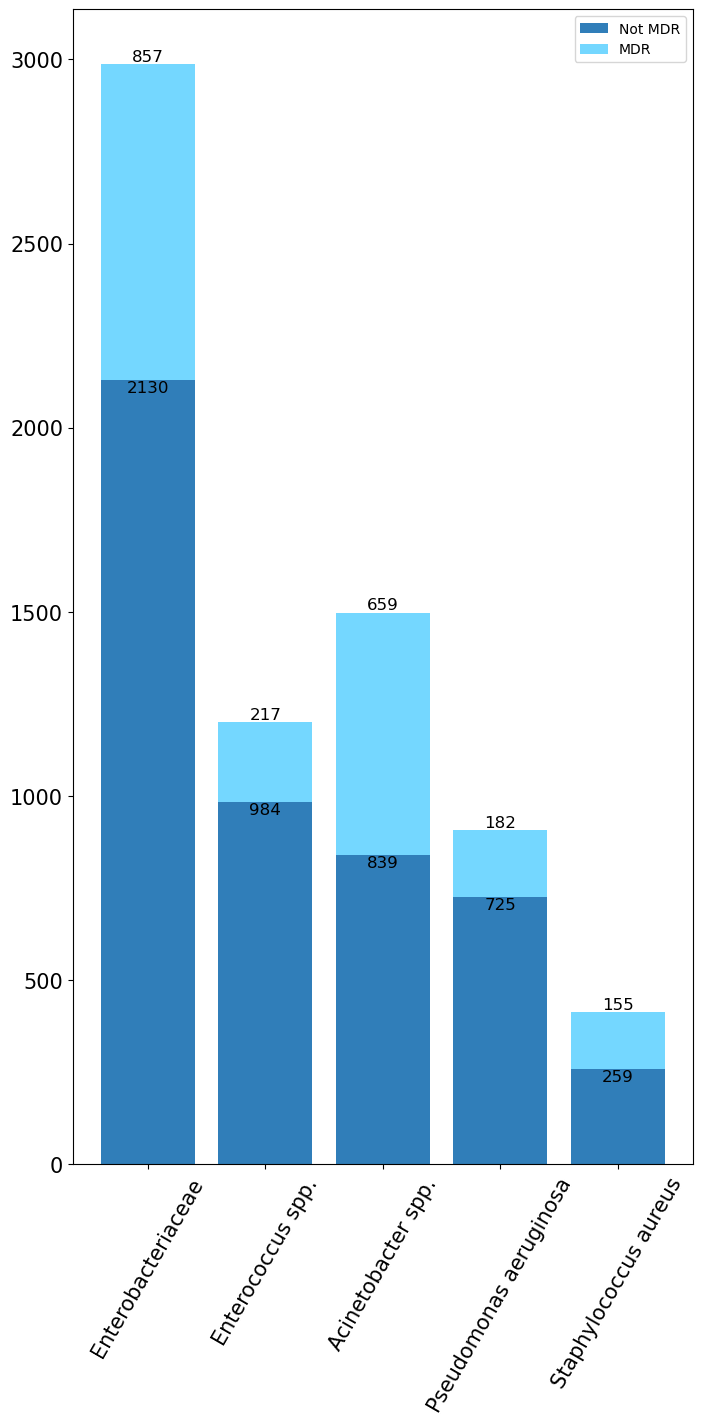

In [29]:
mdr_plot_cat = micro_sel[['micro_name','org_category','MDR']]
#mdr_plot_cat = pd.merge(mdr_plot_cat,org_name_sel.iloc[:,1:4],how = 'left', on = 'micro_name')
mdr_plot_cat = mdr_plot_cat[~pd.isna(mdr_plot_cat.org_category)]
mdr_plot_cat_bar1 = pd.DataFrame(mdr_plot_cat[mdr_plot_cat['MDR']==1].groupby(['org_category','MDR']).count()['micro_name']).reset_index().sort_values(by = 'micro_name',ascending = False)
mdr_plot_cat_bar0 = pd.DataFrame(mdr_plot_cat[mdr_plot_cat['MDR']==0].groupby(['org_category','MDR']).count()['micro_name']).reset_index().sort_values(by = 'micro_name',ascending = False)
mdr_plot_cat_bar = pd.merge(mdr_plot_cat_bar1,mdr_plot_cat_bar0,how = 'right', on = 'org_category')
#with plt.style.context(['science','notebook','ieee','no-latex']):
plt.figure(figsize= (8,15))
plt.bar(mdr_plot_cat_bar['org_category'],mdr_plot_cat_bar['micro_name_y'],color='#307eb9',label='Not MDR')
plt.bar(mdr_plot_cat_bar['org_category'],mdr_plot_cat_bar['micro_name_x'],color='#74d7ff',bottom=mdr_plot_cat_bar['micro_name_y'], label = 'MDR')
plt.tick_params(labelsize = 15)
for x1,x2, y1, y2 in zip(mdr_plot_cat_bar['org_category'], mdr_plot_cat_bar['org_category'], mdr_plot_cat_bar['micro_name_y'], mdr_plot_cat_bar['micro_name_x']):
    plt.text(x1 , y1, '%.0f' % y1, ha='center', va='top',fontsize = 12)
    plt.text(x2 , y1+y2, '%.0f' % y2, ha='center', va='bottom',fontsize = 12)
plt.xticks(rotation = 60)
plt.legend(loc=1)

In [30]:
final_cohort_pre_id = final_cohort_pre[['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates()
final_cohort_pre_id['icustay_rank']= final_cohort_pre.groupby(['PATIENT_ID'])['TF_ADMISSION_DATE_TIME'].rank()
final_cohort_pre = pd.merge(final_cohort_pre,final_cohort_pre_id,how = 'right', on = ['PATIENT_ID','TF_ADMISSION_DATE_TIME'])

final_cohort_pre['los_icu_exc'] = final_cohort_pre['LOS_ICU'].apply(lambda x:1 if x < 1 else 0)

final_cohort_stage0 = final_cohort_pre[final_cohort_pre['stay_chart_included'] == 1]

final_cohort_stage1 = final_cohort_stage0[final_cohort_stage0['AGE']>=18]

final_cohort_stage2 = final_cohort_stage1[final_cohort_stage1['los_icu_exc']==0]

final_cohort_stage3 = final_cohort_stage2[(final_cohort_stage2['previous_mdrpos_lessthan14d'] != 1)& (final_cohort_stage2['previous_mdrneg_lessthan14d'] != 1)]

In [31]:
final_cohort_stage0[['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(23019, 2)

In [32]:
final_cohort_stage3[final_cohort_stage3['previous_mdrpos_lessthan90d']==1].stay_chart_included_mdr.value_counts()

0.0    60
1.0    30
Name: stay_chart_included_mdr, dtype: int64

In [33]:
final_cohort_stage3[final_cohort_stage3['previous_mdrneg_lessthan90d']==1].stay_chart_included_mdr.value_counts()

0.0    195
1.0    113
Name: stay_chart_included_mdr, dtype: int64

In [34]:
final_cohort_stage3[final_cohort_stage3['stay_chart_included_mdr']==1].stay_chart_included_mdr_pos_tot.value_counts()

0.0    1218
1.0     286
Name: stay_chart_included_mdr_pos_tot, dtype: int64

In [35]:
final_cohort_stage3.stay_chart_included_mdr.value_counts()

0.0    18273
1.0     1504
Name: stay_chart_included_mdr, dtype: int64

In [36]:
final_cohort_stage3['los_hosp_beforeicu'] = \
(final_cohort_stage3['TF_ADMISSION_DATE_TIME'] - final_cohort_stage3['ADMISSION_DATE_TIME']).dt.total_seconds()/(3600*24)

/tmp/ipykernel_2713993/1784526656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cohort_stage3['los_hosp_beforeicu'] = \


In [37]:
final_cohort_stage3[(final_cohort_stage3['AGE']>=18)][['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(19777, 2)

In [38]:
final_cohort_stage3.stay_chart_included_mdr.value_counts()

0.0    18273
1.0     1504
Name: stay_chart_included_mdr, dtype: int64

In [39]:
final_cohort_stage3[final_cohort_stage3['AGE']<18]

,PATIENT_ID,VISIT_ID,GENDER,AGE,ADMISSION_DATE_TIME,DISCHARGE_DATE_TIME,ADMISSION_TYPE,ICU_TYPE,TF_ADMISSION_DATE_TIME,TF_DISCHARGE_DATE_TIME,LOS_ICU,firsthospmdrcharttime,firsthospmdrstoretime,firsthospmdrRAB,firsthospmdrorgname,previous_mdrpos_lessthan7d,previous_mdrneg_lessthan7d,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,stay_chart_included,stay_chart_included_mdr,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot,icustay_rank,los_icu_exc,los_hosp_beforeicu


In [40]:
final_cohort_stage3.to_csv('final_cohort.csv', index = False)

In [41]:
final_cohort_pre[final_cohort_pre['ICU_TYPE'] == 'ICU'][['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates()

,PATIENT_ID,TF_ADMISSION_DATE_TIME
3,S110676645,2008-11-17 18:14:08
15,S110666507,2009-05-27 20:56:42
16,S110666507,2009-10-19 19:00:00
17,S112330035,2012-07-06 14:55:00
22,S108951515,2008-09-27 19:45:23
...,...,...
39685,S110433266,2009-06-02 15:10:00
39686,S110823974,2010-03-23 20:26:02
39688,S110016702,2008-07-22 21:43:35
39691,S110446777,2009-06-06 23:04:51


In [42]:
test0 = final_cohort_pre[(final_cohort_pre['ICU_TYPE'] == 'ICU')&(final_cohort_pre['stay_chart_included'] == 1)]

test1 = test0[test0['AGE']>=18]

test2 = test1[test1['los_icu_exc']==0]

test3 = test2[(test2['previous_mdrpos_lessthan14d'] != 1)&(test2['previous_mdrneg_lessthan14d'] != 1)]

In [43]:
final_cohort_pre[final_cohort_pre['ICU_TYPE'] == 'ICU'].shape

(5718, 25)

In [44]:
test0[['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(4039, 2)

In [45]:
test1[['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(3978, 2)

In [46]:
test2[['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(3645, 2)

In [47]:
test3[['PATIENT_ID','TF_ADMISSION_DATE_TIME']].drop_duplicates().shape

(3537, 2)

In [48]:
test3[test3['icustay_rank'] == 1.5]

,PATIENT_ID,VISIT_ID,GENDER,AGE,ADMISSION_DATE_TIME,DISCHARGE_DATE_TIME,ADMISSION_TYPE,ICU_TYPE,TF_ADMISSION_DATE_TIME,TF_DISCHARGE_DATE_TIME,LOS_ICU,firsthospmdrcharttime,firsthospmdrstoretime,firsthospmdrRAB,firsthospmdrorgname,previous_mdrpos_lessthan7d,previous_mdrneg_lessthan7d,previous_mdrpos_lessthan90d,previous_mdrneg_lessthan90d,stay_chart_included,stay_chart_included_mdr,stay_chart_included_mdr_neg_tot,stay_chart_included_mdr_pos_tot,icustay_rank,los_icu_exc


In [49]:
from tableone import TableOne

In [50]:
test3.columns

Index(['PATIENT_ID', 'VISIT_ID', 'GENDER', 'AGE', 'ADMISSION_DATE_TIME',
       'DISCHARGE_DATE_TIME', 'ADMISSION_TYPE', 'ICU_TYPE',
       'TF_ADMISSION_DATE_TIME', 'TF_DISCHARGE_DATE_TIME', 'LOS_ICU',
       'firsthospmdrcharttime', 'firsthospmdrstoretime', 'firsthospmdrRAB',
       'firsthospmdrorgname', 'previous_mdrpos_lessthan7d',
       'previous_mdrneg_lessthan7d', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d', 'stay_chart_included',
       'stay_chart_included_mdr', 'stay_chart_included_mdr_neg_tot',
       'stay_chart_included_mdr_pos_tot', 'icustay_rank', 'los_icu_exc'],
      dtype='object')

In [51]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return parse(t)

In [52]:
mort = pd.read_csv('../Local_hosp_data/mort.csv')

mort['DOD_HOSP'] = mort['DOD_HOSP'].apply(trans_time)

test3 = pd.merge(test3, mort, how = 'left', on = ['PATIENT_ID','VISIT_ID'])

# test3['DISCHARGE_DATE_TIME'] = test3['DISCHARGE_DATE_TIME'].apply(trans_time)

# test3['ADMISSION_DATE_TIME'] = test3['ADMISSION_DATE_TIME'].apply(trans_time)

test3['DOD'] = \
test3[['ADMISSION_DATE_TIME','DISCHARGE_DATE_TIME','DOD_HOSP']].\
apply(lambda x: 1 if ((x[2]-x[0]).total_seconds()>=0) and ((x[2]-x[1]).total_seconds()<=0) else 0, axis = 1)

In [53]:
test3.columns

Index(['PATIENT_ID', 'VISIT_ID', 'GENDER', 'AGE', 'ADMISSION_DATE_TIME',
       'DISCHARGE_DATE_TIME', 'ADMISSION_TYPE', 'ICU_TYPE',
       'TF_ADMISSION_DATE_TIME', 'TF_DISCHARGE_DATE_TIME', 'LOS_ICU',
       'firsthospmdrcharttime', 'firsthospmdrstoretime', 'firsthospmdrRAB',
       'firsthospmdrorgname', 'previous_mdrpos_lessthan7d',
       'previous_mdrneg_lessthan7d', 'previous_mdrpos_lessthan90d',
       'previous_mdrneg_lessthan90d', 'stay_chart_included',
       'stay_chart_included_mdr', 'stay_chart_included_mdr_neg_tot',
       'stay_chart_included_mdr_pos_tot', 'icustay_rank', 'los_icu_exc',
       'DOD_HOSP', 'DOD'],
      dtype='object')

In [54]:
columns_dev_ini = [
 'GENDER', 'AGE','LOS_ICU','DOD',
 'previous_mdrpos_lessthan90d',
'previous_mdrneg_lessthan90d',
'stay_chart_included_mdr'
]

nonnormal_dev_ini = [
 'AGE','LOS_ICU'
]

category_dev_ini = [
 'GENDER', 'DOD',
'stay_chart_included_mdr'
]
groupby_ini = ['stay_chart_included_mdr']
tableone_ = TableOne(test3,
                      nonnormal=nonnormal_dev_ini,
                            categorical=category_dev_ini,
                            columns=columns_dev_ini,
                            groupby=groupby_ini,
                            label_suffix=True,
                            pval=True,
                            htest_name=True)

In [55]:
tableone_.to_csv('table_one.csv')